<a href="https://colab.research.google.com/github/pksX01/AI-practice/blob/main/CNN/transfer_learning_cnn_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub
path = kagglehub.dataset_download("zalando-research/fashionmnist")

Using Colab cache for faster access to the 'fashionmnist' dataset.


In [ ]:
path

'/kaggle/input/fashionmnist'

In [ ]:
!ls $path

fashion-mnist_test.csv	 t10k-images-idx3-ubyte  train-images-idx3-ubyte
fashion-mnist_train.csv  t10k-labels-idx1-ubyte  train-labels-idx1-ubyte


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [ ]:
torch.manual_seed(42)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
train_df = pd.read_csv(f"{path}/fashion-mnist_train.csv")

In [ ]:
test_df = pd.read_csv(f"{path}/fashion-mnist_test.csv")

In [ ]:
train_df.shape

(60000, 785)

In [ ]:
test_df.shape

(10000, 785)

In [ ]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


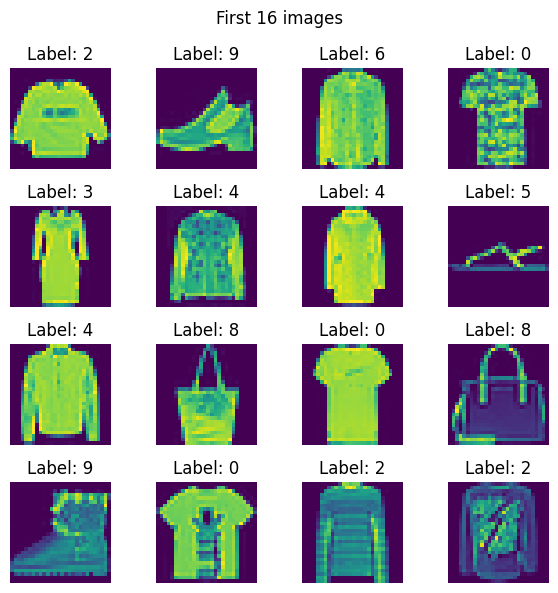

In [ ]:
fig, axes = plt.subplots(4,4, figsize=(6,6))
fig.suptitle('First 16 images')
for i, ax in enumerate(axes.flat):
    ax.imshow(train_df.iloc[i,1:].values.reshape(28,28))
    ax.axis('off')
    ax.set_title(f"Label: {train_df.iloc[i,0]}")
plt.tight_layout(rect = [0, 0, 1, 1])
plt.show()

In [ ]:
X_train = train_df.iloc[:, 1:]
y_train = train_df.iloc[:, 0]
X_test = test_df.iloc[:, 1:]
y_test = test_df.iloc[:, 0]

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

In [ ]:
from torchvision import transforms
import numpy as np
from PIL import Image

In [ ]:
img = X_train.iloc[0,:].values.reshape(28,28)

In [ ]:
img.shape

(28, 28)

In [ ]:
np.stack([img]*3).shape

(3, 28, 28)

In [ ]:
custom_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, features, labels, transform):
        self.features = features
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        img = self.features.iloc[index,:].values.reshape(28,28)
        img = img.astype(np.uint8)
        img = np.stack([img]*3, axis=-1)
        img = Image.fromarray(img)
        img = self.transform(img)
        return img, torch.tensor(self.labels[index], dtype=torch.long)

In [ ]:
train_ds = CustomDataset(X_train, y_train, transform=custom_transforms)

In [ ]:
train_ds

In [ ]:
test_ds = CustomDataset(X_test, y_test, transform=custom_transforms)

In [ ]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, pin_memory=True)

In [ ]:
from torchvision.models import vgg16
model = vgg16(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [ ]:
model.avgpool

AdaptiveAvgPool2d(output_size=(7, 7))

In [ ]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [ ]:
for param in model.features.parameters():
    param.requires_grad = False

In [ ]:
model.classifier = nn.Sequential(
    nn.Linear(25088, 512),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(256, 10)
)

In [ ]:
model = model.to(device)

In [ ]:
learning_rate = 0.0001
epochs = 10

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(epochs):
    total_epoch_loss = 0
    for batch_features, batch_labels in train_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_epoch_loss += loss.item()
    avg_epoch_loss = total_epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1}:", avg_epoch_loss)


Epoch 1: 0.16341123781700928
Epoch 2: 0.11680608949561914
Epoch 3: 0.08336980845555664
Epoch 4: 0.061095478955221674
Epoch 5: 0.04597125062310758
Epoch 6: 0.03610264611540673
Epoch 7: 0.030079153219932535
Epoch 8: 0.025588280614856195
Epoch 9: 0.02252298819171459
Epoch 10: 0.02001535825713921


In [ ]:
 model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
total, correct = 0, 0
with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        outputs = model(batch_features)
        _, preds = torch.max(outputs, 1)
        total += batch_labels.shape[0]
        correct += (preds == batch_labels).sum().item()
print(f"Test Accuracy: {correct*100/total}")

Test Accuracy: 93.39


In [ ]:
total, correct = 0, 0
with torch.no_grad():
    for batch_features, batch_labels in train_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        outputs = model(batch_features)
        _, preds = torch.max(outputs, 1)
        total += batch_labels.shape[0]
        correct += (preds == batch_labels).sum().item()
print(f"Train Accuracy: {correct*100/total}")

Train Accuracy: 99.91166666666666
